In [1]:
# Example of how to use the CGMFtk package
# TRANSFORM THIS NOTEBOOK INTO A VALIDATION SCRIPT FOR A CGMF HISTORY FILE
# I NEED TO ADD 

<div class="alert alert-block alert-info"> <b>NOTE</b> Use blue boxes for Tips and notes. </div>

<div class="alert alert-block alert-success">     Use green boxes sparingly, and only for some specific purpose that the other boxes can't cover. For example, if you have a lot of related content to link to, maybe you decide to use green boxes for related links from each section of a notebook. </div>

<div class="alert alert-block alert-warning"> Some notes
<ul>
    <li>I need to add experimental data from EXFOR or from my own curated database</li>
</ul>
</div>

<div class="alert alert-block alert-danger"> In general, just avoid the red boxes. </div>

# Table of Contents
1. [Import Modules](#import)
2. [Read the History File](#read)
3. [Summary Table](#table)
4. [Histogram Fission Fragment Properties](#ffHistograms)
5. [Correlated Observables](#correlations)
6. [Neutron Properties](#neutrons)
7. [Gamma Properties](#gammas)
8. [Gamma-ray Timing Information](#timing)
9. [Angular Correlations](#angles)

### 1. import modules for the notebook
<a id='import'></a>

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from CGMFtk import histories as fh

In [13]:
from VVCGMF import VV

In [2]:
import matplotlib as mpl
plt.style.use('myplottingstyle.mplstyle')

In [132]:
# define a working directory where the history files are stored
BASEDIR = '/Users/stardust/LANL/calculus/CGMF/Validation/'
workdir = BASEDIR + 'CGMF-111-results/'
histFile = '93237nf/hist.93237nf.20.0MeV.1m.cgmf'
#timeFile = '92235_timing.cgmf' # example file with gamma timing information

### 2. Read CGMF history file
<a id='read'></a>

In [133]:
hist = fh.Histories(workdir + histFile,nevents=100000)

In [134]:
# print the number of events in the file
print ('This file contains ',str(hist.getNumberEvents()),' events and ',str(hist.getNumberFragments()),' fission fragments')

This file contains  100000  events and  200000  fission fragments


<div class="alert alert-block alert-success">
    
<b>What's the plan?</b> Probably...

1. Read a result file from CGMF containing a number of histories
2. Verify that it can be read properly and that all numerical values are not absurd or NaN
3. Read a base result file from CGMF-1.1.1 (for instance) and note any "anomaly" of the new file against it = differences between different CGMF versions - or even better, create base concise result files that can be compared to new results. It would save time!
5. Read an experimental file (JSON or CSV) and compare CGMF results to it - note any strong deviations and provide a concise report
6. Include figures in the report

</div>

## Create CSV files of CGMF results (summary)

<div class="alert alert-block alert-danger"> I need to include pre-fission neutrons, when applicable, as well as TKEpost data. </div>

In [306]:
def saveMeanValuesToDataFrame (h):

    data = {
        'Masses':  [np.mean(h.A), np.mean(h.Al), np.mean(h.Ah)],
        'Charges': [np.mean(h.Z), np.mean(h.Zl), np.mean(h.Zh)],
        'Spin':    [np.mean(h.J), np.mean(h.Jl), np.mean(hist.Jh)],
        'Parity':  [np.mean(h.P), np.mean(h.Pl), np.mean(hist.Ph)],

        # energies
        'TXE':     [np.mean(h.TXE),    np.mean(h.Ul),  np.mean(h.Uh)],
        'TKEpre':  [np.mean(h.TKEpre), np.mean(h.KEl), np.mean(h.KEh)],

        # neutrons
        'nubar':   [np.mean(h.nuLF+hist.nuHF),    np.mean(h.nuLF),       np.mean(h.nuHF)], #, np.mean(hist.preFissionNu)] can't handle non-uniform size arrays
        'Ecm':     [h.meanNeutronEcmFragments(),  h.meanNeutronEcmLF(),  h.meanNeutronEcmHF()],
        'Elab':    [h.meanNeutronElabFragments(), h.meanNeutronElabLF(), h.meanNeutronElabHF()],

        # gammas
        'nug':     [np.mean(h.nugtot), np.mean(h.nugLF),    np.mean(h.nugHF)],
        'Eglab':   [h.meanGammaElab(), h.meanGammaElabLF(), h.meanGammaElabHF()]
    }

    df = pd.DataFrame(data)

    return df
    

In [307]:
def saveMeanValuesToFile (h, filename):

    df = saveMeanValuesToDataFrame (h)
    df.to_csv(filename, float_format='%.3f', index=False)

    return
    

In [308]:
#reactions = ['92233nf', '92235nf', '92238nf', '93237nf', '94238sf', '94239nf', '94240sf', '94241nf', '94242sf', '94244sf', '98252sf', '98254sf']
#Einc = ['2.53e-8', '5.0', '10.0', '15.0', '20.0']
reactions = ['94239nf']
Einc = ['2.53e-8']

nfe = 100000 # number of fission events to read (must be smaller than the number of events recorded in CGMF output file)

for reaction in reactions:
    
    basename = reaction+'/hist.'+reaction+'.'
    
    print ('*** '+reaction+' ***')

    if ('sf' in reaction):
        histFile = basename+'1m.cgmf'
        print ('Spontaneous Fission - ', histFile)
        hist = fh.Histories(workdir + histFile, nevents=nfe)
        saveMeanValuesToFile (hist, workdir+reaction+'/summary.'+reaction+'.1m.csv')
    else:
        for E in Einc:
            histFile = basename+E+'MeV.1m.cgmf'
            print (E, 'MeV - ', histFile)
            hist = fh.Histories(workdir + histFile, nevents=nfe)
            saveMeanValuesToFile (hist, workdir+reaction+'/summary.'+reaction+'.'+E+'MeV.1m.csv')



*** 94239nf ***
2.53e-8 MeV -  94239nf/hist.94239nf.2.53e-8MeV.1m.cgmf


## Validate new results against baseline

In [194]:
reaction = '94239nf'
energy = '2.53e-8'
histFile0 = reaction+'/'+'hist.'+reaction+'.'+energy+'MeV.1m.cgmf'
sumFile0 = reaction+'/'+'summary.'+reaction+'.'+energy+'MeV.1m.csv'

In [195]:
df0 = pd.read_csv (workdir+sumFile0)
df0

,Masses,Charges,Spin,Parity,TXE,TKEpre,nubar,Ecm,Elab,nug,Eglab
0,120.000,47.000,9.566,-0.002,26.09,178.202,2.870,1.243,2.003,8.133,0.796
1,100.534,39.792,8.764,-0.002,13.09,103.407,1.423,1.191,2.195,4.238,0.767
2,139.466,54.208,10.367,-0.002,13.00,74.794,1.447,1.295,1.813,3.895,0.828


In [289]:
histFile = reaction+'/'+'hist.'+reaction+'.'+energy+'MeV.1m.cgmf'
hist = fh.Histories(workdir + histFile, nevents=50000)

In [290]:
df = saveMeanValuesToDataFrame (hist)
print (histFile)

94239nf/hist.94239nf.2.53e-8MeV.1m.cgmf


In [291]:
print (np.mean(hist.nuLF), df0['nubar'][1], df['nubar'][1])

1.4182 1.423 1.4182


In [292]:
def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('First', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

#df_final.style.apply(highlight_diff, axis=None)

In [293]:
df0

,Masses,Charges,Spin,Parity,TXE,TKEpre,nubar,Ecm,Elab,nug,Eglab
0,120.000,47.000,9.566,-0.002,26.09,178.202,2.870,1.243,2.003,8.133,0.796
1,100.534,39.792,8.764,-0.002,13.09,103.407,1.423,1.191,2.195,4.238,0.767
2,139.466,54.208,10.367,-0.002,13.00,74.794,1.447,1.295,1.813,3.895,0.828


In [294]:
df

,Masses,Charges,Spin,Parity,TXE,TKEpre,nubar,Ecm,Elab,nug,Eglab
0,120.00000,47.00000,9.56052,0.00014,26.057946,178.227043,2.86586,1.241634,2.004389,8.14084,0.796071
1,100.51994,39.78778,8.75673,0.00124,13.063525,103.430102,1.41820,1.189615,2.200565,4.24010,0.768644
2,139.48006,54.21222,10.36431,-0.00096,12.994422,74.796941,1.44766,1.292594,1.812205,3.90074,0.825883


In [299]:
import datacompy

/var/folders/2j/f1mgz7p11vb_0xbh76c_5tfh0000gr/T/ipykernel_92550/2230815041.py:1: UserWarning: Python 3.12 and above currently is not supported by Spark and Ray. Please note that some functionality will not work and currently is not supported.
  import datacompy


In [304]:
compare = datacompy.Compare(df0, df, join_columns=['Masses'])

In [296]:
from pandas.testing import assert_frame_equal

try:
    assert_frame_equal(df0, df, rtol=0.005, atol=0.001)
    print ("DataFrames are equal within tolerance.")
except AssertionError as e:
    print ("DataFrames are not equal within tolerance:")
    print (e)

DataFrames are not equal within tolerance:
DataFrame.iloc[:, 3] (column name="Parity") are different

DataFrame.iloc[:, 3] (column name="Parity") values are different (100.0 %)
[index]: [0, 1, 2]
[left]:  [-0.002, -0.002, -0.002]
[right]: [0.00014, 0.00124, -0.00096]
At positional index 0, first diff: -0.002 != 0.00014


In [212]:
lstyles = [
    ["background-color:lightcoral" # <-- adjust the color here
    if v in df0.set_index("").T.to_dict("list").get(k, []) else ""
    for v in vals] for k, *vals in df.values
]

#use_cols = df_all.columns.difference(["Key"])

#out = (
#    df_all.style.apply(lambda _: pd.DataFrame(lstyles, columns=use_cols),
#                       axis=None, subset=use_cols)
#)

KeyError: "None of [''] are in the columns"

## Validate new results against experimental data

## Validate new results against evaluated data

In [84]:
VV(hist).A

array([ 92, 146, 101, ..., 133,  98, 139])

With the option 'nevents', the number of fission events that are read can be specified:

hist = fh.Histories('92235_1MeV.cgmf',nevents=5000)

### 3. Summary Table
<a id='table'></a>

In [135]:
# provide a summary table of the fission events
hist.summaryTable()

[['',
  'All Fragments',
  'Light Fragments',
  'Heavy Fragments',
  'Pre-Fission',
  'Total'],
 ['A', '118.26', '98.17', '138.35'],
 ['Z', '46.50', '39.23', '53.77'],
 ['TXE / U (MeV)', '35.87', '20.03', '15.84'],
 ['TKE / KE (MeV)', '171.83', '100.35', '71.47'],
 ['J ($\\hbar$)', '11.70', '11.08', '12.32'],
 ['parity', ' 0.00', ' 0.00', ' 0.00'],
 ['$\\langle \\nu\\rangle$', '3.933', '2.170', '1.763', '1.480', '5.414'],
 ['$\\langle \\epsilon_n^{cm}\\rangle$ (MeV)', '1.452', '1.485', '1.411'],
 ['$\\langle E_n^{lab}\\rangle$ (MeV)',
  '2.236',
  '2.504',
  '1.907',
  '2.278',
  '2.248'],
 ['$\\langle \\nu_\\gamma\\rangle$', ' 8.88', ' 4.55', ' 4.33'],
 ['$\\langle E_\\gamma^{lab}\\rangle$ (MeV)', ' 0.85', ' 0.87', ' 0.82']]

### 4. Fission Fragment Properties
<a id='ffHistograms'></a>

With the histogram function from matplotlib, we can easily plot distributions of the fission fragment characteristics

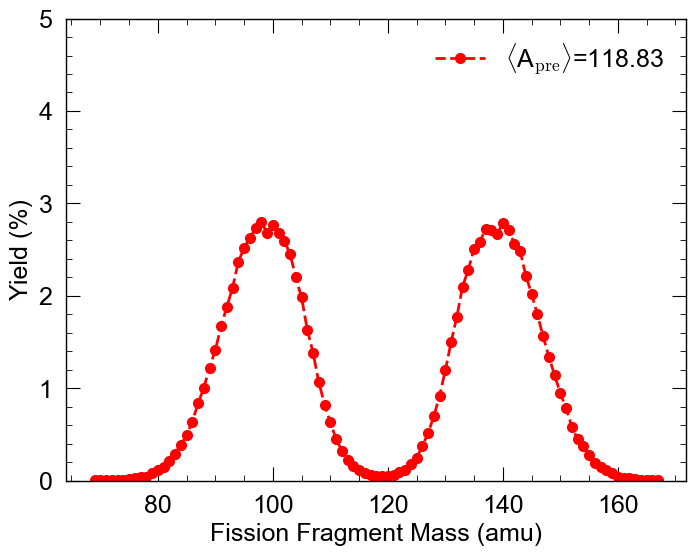

In [52]:
# plot the distributions of the fission fragments
fig = plt.figure(figsize=(8,6))
Apre= hist.getA() # get A of all fragments
#Apost = A - hist.nubarA()
AL = hist.getALF() # get A of light fragments
AH = hist.getAHF() # get A of heavy fragments
plt.ylim(0,5)
bins = np.arange(min(Apre),max(Apre))
h,b = np.histogram(Apre,bins=bins,density=True)
plt.plot(b[:-1],h*100,'ro--',label=r'$\langle$A$_{\rm pre}\rangle$=%.2f'%(np.mean(Apre)))
#h,b = np.histogram(Apost,bins=bins,density=True)
#plt.plot(b[:-1],h,'bs--',label=r'$\langle$A$_{\rm post}\rangle$=%.2f'%(np.mean(Apost)))
plt.legend()
plt.xlabel('Fission Fragment Mass (amu)')
plt.ylabel('Yield (%)')
plt.show()
fig.savefig(workdir+'YA.pdf')

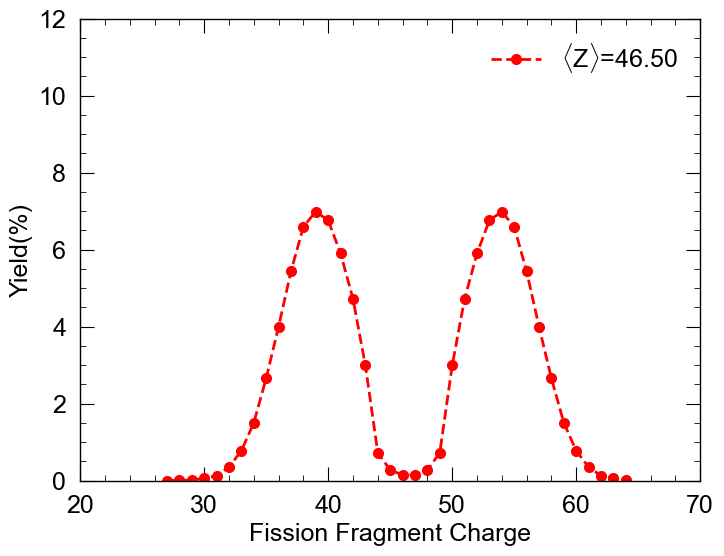

In [53]:
fig = plt.figure(figsize=(8,6))
Z = hist.getZ()
ZL = hist.getZLF()
ZH = hist.getZHF()
bins = np.arange(min(Z),max(Z))
h,b = np.histogram(Z,bins=bins,density=True)
plt.ylim(0,12)
plt.plot(b[:-1],h*100,'ro--',label=r'$\langle$Z$\rangle$=%.2f'%(np.mean(Z)))
plt.xlabel('Fission Fragment Charge')
plt.ylabel('Yield(%)')
plt.xlim(20,70)
plt.legend()
plt.show()
fig.savefig(workdir+'YZ.pdf')

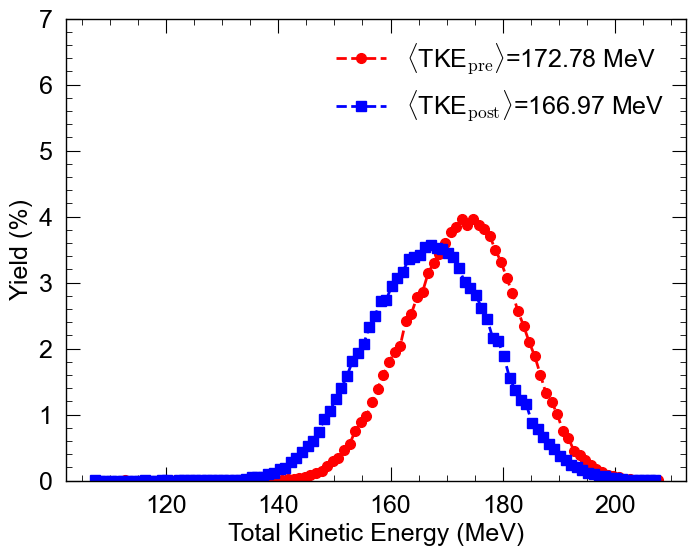

In [54]:
fig = plt.figure(figsize=(8,6))
TKEpre = hist.getTKEpre() # TKE before neutron emission
TKEpost = hist.getTKEpost() # TKE after neutron emission
plt.ylim(0,7)
bins = np.arange(min(TKEpre),max(TKEpre))
h,b = np.histogram(TKEpre,bins=bins,density=True)
plt.plot(0.5*(b[:-1]+b[1:]),h*100,'ro--',label=r'$\langle$TKE$_{\rm pre}\rangle$=%.2f MeV'%(np.mean(TKEpre)))
bins = np.arange(min(TKEpost),max(TKEpost))
h,b = np.histogram(TKEpost,bins=bins,density=True)
plt.plot(0.5*(b[:-1]+b[1:]),h*100,'bs--',label=r'$\langle$TKE$_{\rm post}\rangle$=%.2f MeV'%(np.mean(TKEpost)))
plt.legend()
plt.xlabel('Total Kinetic Energy (MeV)')
plt.ylabel('Yield (%)')
plt.show()
fig.savefig(workdir+'YTKE.pdf')

With the 2D histogram feature, we can see correlations between the calculated features from CGMF

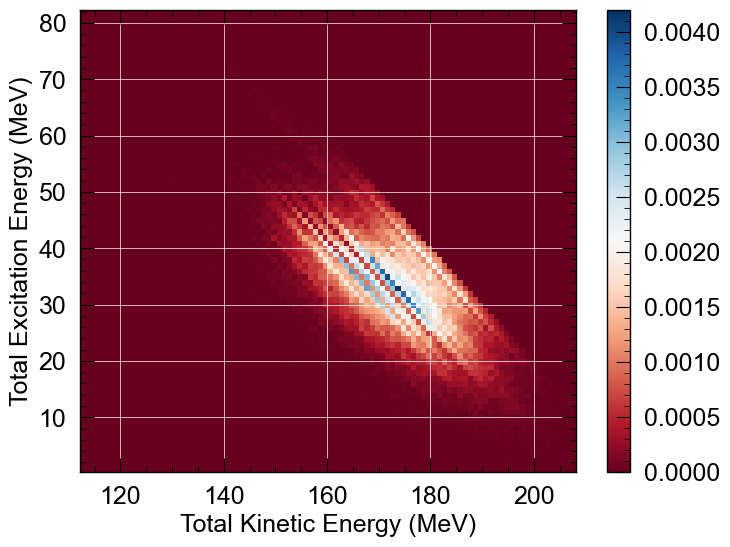

In [55]:
TKEpre = hist.getTKEpre()
TXE = hist.getTXE()
bx = np.arange(min(TKEpre),max(TKEpre))
by = np.arange(min(TXE),max(TXE))
fig = plt.figure(figsize=(8,6))
plt.hist2d(TKEpre,TXE,bins=(bx,by),density=True)
plt.xlabel('Total Kinetic Energy (MeV)')
plt.ylabel('Total Excitation Energy (MeV)')
plt.colorbar()
plt.show()

### 5. Correlated Observables
<a id='correlations'></a>

Many observables within fission are correlated with one another.  Sometimes, these are best visualized as two-dimensional histograms as in the TKE-TXE plot directly above.  Other times, it is helpful to plot certain observables as a function of mass or TKE.  There are routines within CGMFtk that easily construct those, as demonstrated here:

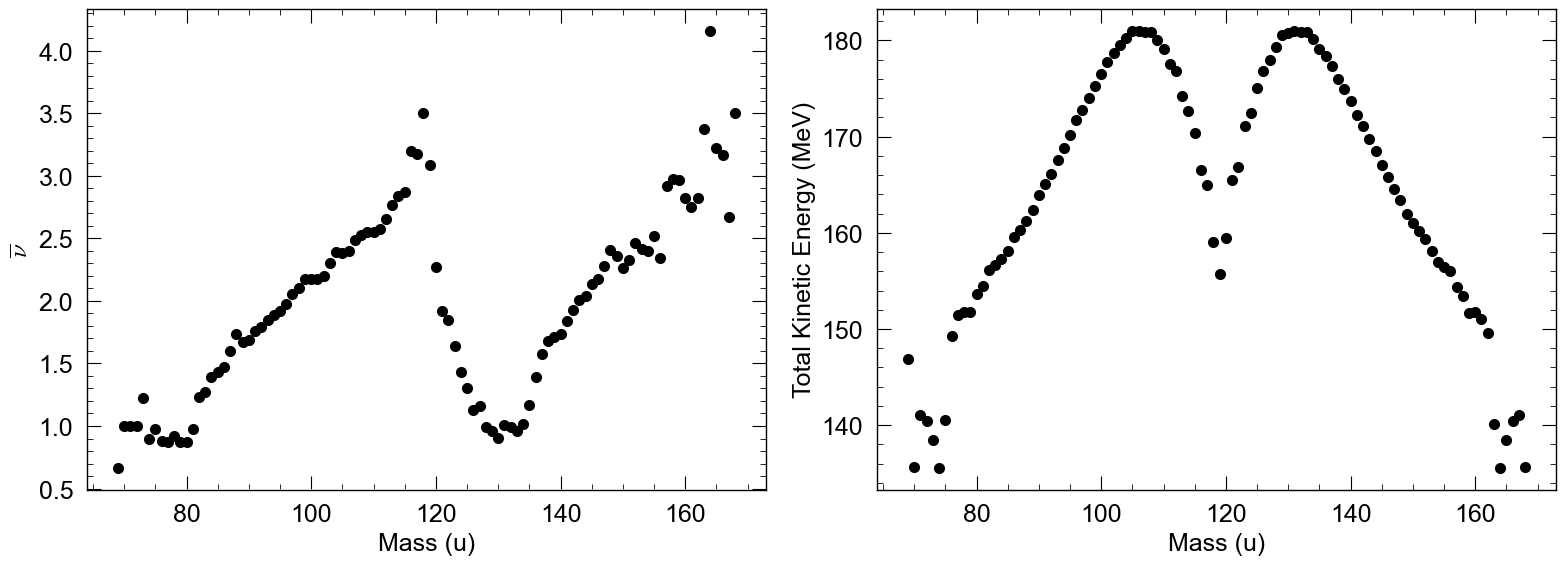

In [56]:
# nubar as a function of mass
## nubarg, excitation energy, kinetic energy (pre), and spin are available as a function of mass
nubarA = hist.nubarA()
TKEA = hist.TKEA()
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(nubarA[0],nubarA[1],'ko')
plt.xlabel('Mass (u)')
plt.ylabel(r'$\overline{\nu}$')
plt.subplot(122)
plt.plot(TKEA[0],TKEA[1],'ko')
plt.xlabel('Mass (u)')
plt.ylabel(r'Total Kinetic Energy (MeV)')
plt.tight_layout()
plt.show()

### 6. Neutron properties
<a id='neutrons'></a>

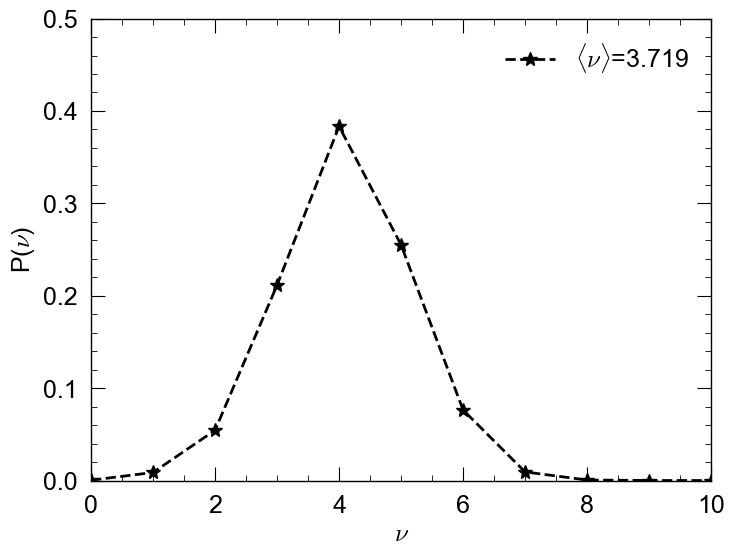

In [57]:
# construct and plot the neutron multiplicity distribution
nu,pnu = hist.Pnu()
fig = plt.figure(figsize=(8,6))
plt.xlim(0,10)
plt.ylim(0,0.5)
plt.plot(nu,pnu,'k*--',markersize=10,label=r'$\langle \nu \rangle$=%.3f'%(np.mean(nu*pnu)*10))
plt.xlabel(r'$\nu$')
plt.ylabel(r'P($\nu$)')
plt.legend()
plt.show()

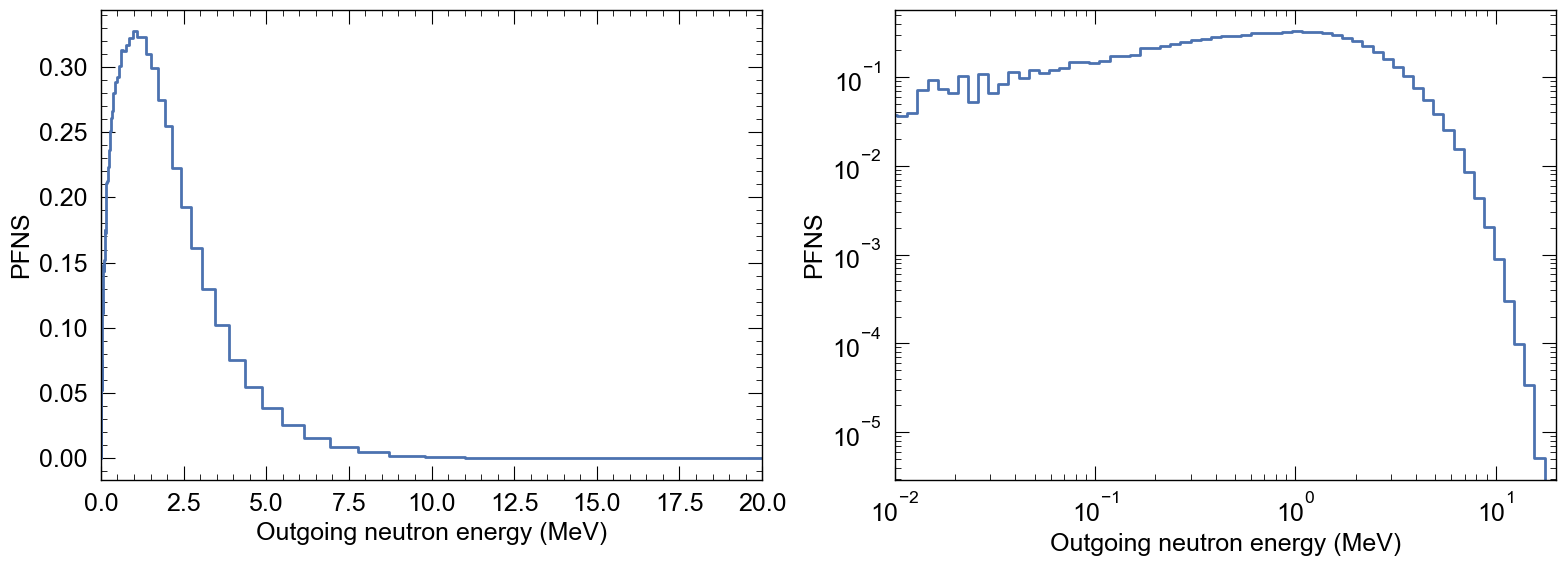

In [58]:
# construct and plot the prompt neutron spectrum
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
ebins,pfns = hist.pfns()
plt.step(ebins,pfns,where='mid')
plt.xlim(0,20)
plt.xlabel('Outgoing neutron energy (MeV)')
plt.ylabel('PFNS')
plt.subplot(122)
plt.step(ebins,pfns,where='mid')
plt.xlim(0.01,20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Outgoing neutron energy (MeV)')
plt.ylabel('PFNS')
plt.tight_layout()
plt.show()

In [59]:
# average number of prompt neutrons
print ('nubar (per fission event) = ',hist.nubartot())
print ('average number of neutrons per fragment = ',hist.nubar())

nubar (per fission event) =  4.09051
average number of neutrons per fragment =  1.879525


In [60]:
# average neutron energies
print ('Neutron energies in the lab:')
print ('Average energy of all neutrons = ',hist.meanNeutronElab())
print ('Average energy of neutrons from fragments = ',hist.meanNeutronElabFragments())
print ('Average energy of neutrons from light fragment = ',hist.meanNeutronElabLF())
print ('Average energy of neutrons from heavy fragment = ',hist.meanNeutronElabHF())
print (' ')
print ('Neutron energies in the center of mass:')
print ('Average energy of neutrons from fragments = ',hist.meanNeutronEcmFragments())
print ('Average energy of neutrons from light fragment = ',hist.meanNeutronEcmLF())
print ('Average energy of neutrons from heavy fragment = ',hist.meanNeutronEcmHF())

Neutron energies in the lab:
Average energy of all neutrons =  2.129383382512205
Average energy of neutrons from fragments =  2.175771764142535
Average energy of neutrons from light fragment =  2.449436770080912
Average energy of neutrons from heavy fragment =  1.838989022009388
 
Neutron energies in the center of mass:
Average energy of neutrons from fragments =  1.3869250874556074
Average energy of neutrons from light fragment =  1.4225596231182427
Average energy of neutrons from heavy fragment =  1.3430718494650453


Note that the energies are not recorded for the pre-fission neutrons in the center of mass frame

### 7. Gamma properties
<a id='gammas'></a>

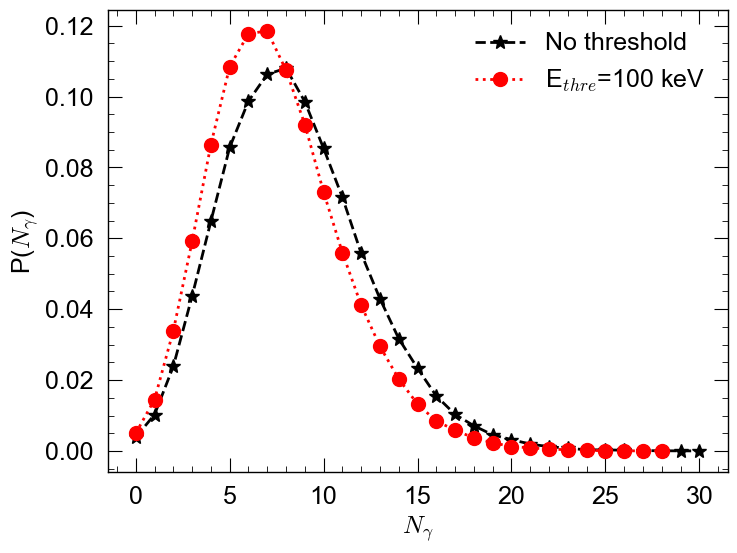

In [40]:
# construct and plot the gamma multiplicity distribution
nug,pnug = hist.Pnug()
# include an energy threshold of 100 keV/0.1 MeV
nugth,pnugth = hist.Pnug(Eth=0.1)
fig = plt.figure(figsize=(8,6))
plt.plot(nug,pnug,'k*--',markersize=10,label='No threshold')
plt.plot(nugth,pnugth,'ro:',markersize=10,label=r'E$_{thre}$=100 keV')
plt.xlabel(r'$N_\gamma$')
plt.ylabel(r'P($N_\gamma$)')
plt.legend()
plt.show()

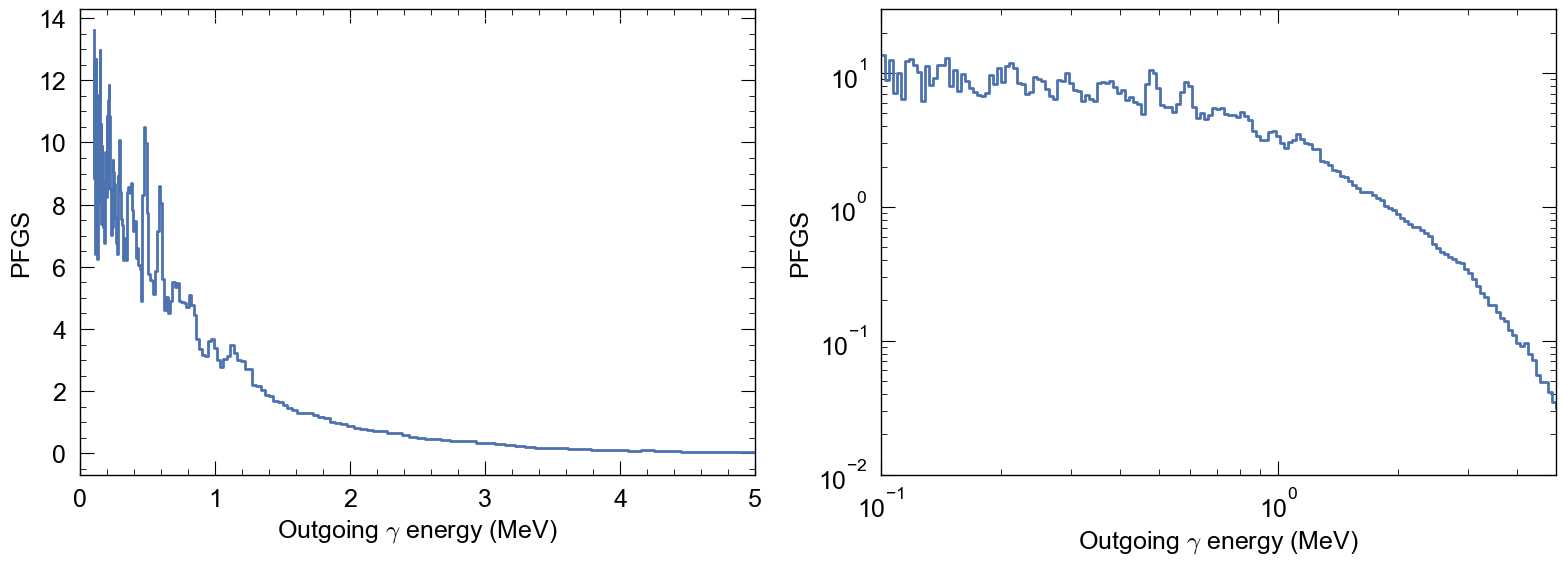

In [41]:
# construct and plot the prompt neutron spectrum
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
ebins,pfgs = hist.pfgs()
plt.step(ebins,pfgs,where='mid')
plt.xlim(0,5)
plt.xlabel(r'Outgoing $\gamma$ energy (MeV)')
plt.ylabel('PFGS')
plt.subplot(122)
plt.step(ebins,pfgs,where='mid')
plt.xlim(0.1,5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Outgoing $\gamma$ energy (MeV)')
plt.ylabel('PFGS')
plt.ylim(1e-2,30)
plt.tight_layout()
plt.show()

In [42]:
# average number of prompt gamma rays
print ('nugbar (per fission event) = ',hist.nubargtot())
print ('average number of gammas per fragment = ',hist.nubarg())
# average number of prompt gamma rays, with an energy threshold, Eth [in MeV]
Enth = 0.1 # 100 keV/0.1 MeV
print ('nugbar (per fission event) = ',hist.nubargtot(Eth=Enth))
print ('average number of gammas per fragment = ',hist.nubarg(Eth=Enth))

nugbar (per fission event) =  8.43931
average number of gammas per fragment =  4.219655
nugbar (per fission event) =  7.49396
average number of gammas per fragment =  3.74698


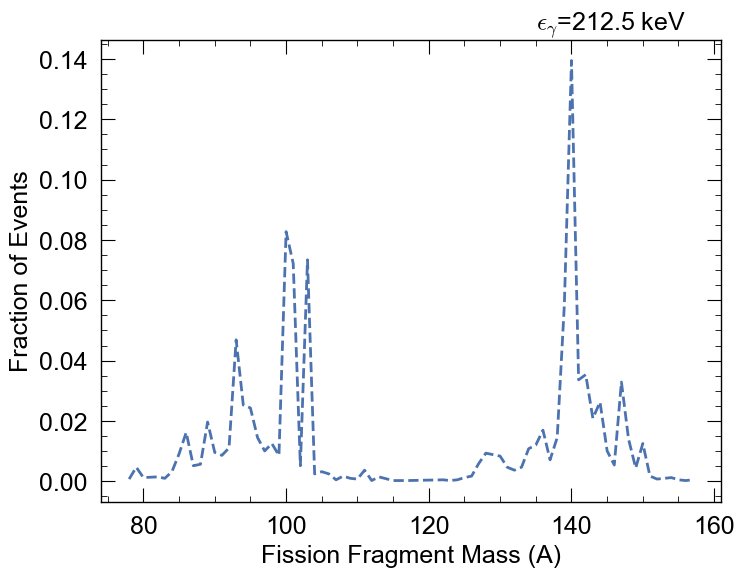

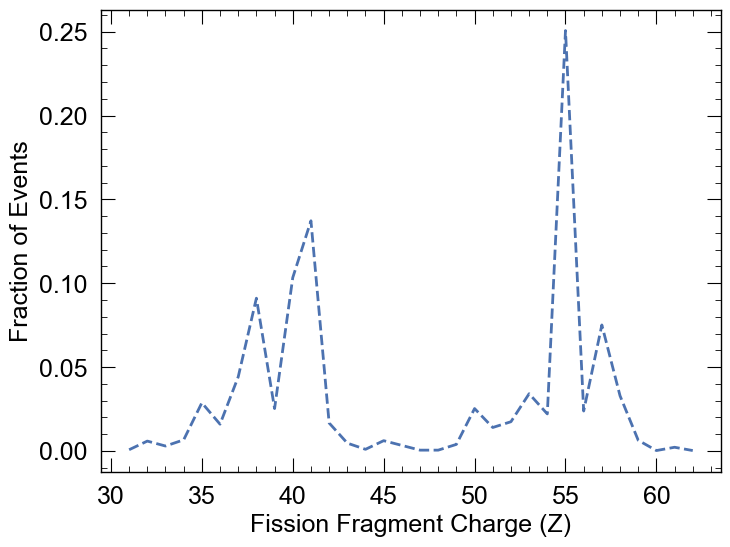

In [43]:
# perform gamma-ray spectroscopy
gE = 0.2125 # gamma ray at 212.5 keV
dE = 0.01 # 1% energy resolution
gspec1 = hist.gammaSpec(gE,dE*gE,post=True)

# calculate the percentage of events for each A/Z
As1 = np.unique(gspec1[:,1])
totEvents = len(gspec1)
fracA1 = []
for A in As1:
    mask = gspec1[:,1]==A
    fracA1.append(len(gspec1[mask])/totEvents)
Zs1 = np.unique(gspec1[:,0])
fracZ1 = []
for Z in Zs1:
    mask = gspec1[:,0]==Z
    fracZ1.append(len(gspec1[mask])/totEvents)

fig = plt.figure(figsize=(8,6))
plt.plot(As1,fracA1,'--')
plt.xlabel('Fission Fragment Mass (A)')
plt.ylabel('Fraction of Events')
plt.text(135,0.150,r'$\epsilon_\gamma$=212.5 keV',fontsize=18)
plt.show()

fig = plt.figure(figsize=(8,6))
plt.plot(Zs1,fracZ1,'--')
plt.xlabel('Fission Fragment Charge (Z)')
plt.ylabel('Fraction of Events')
plt.show()

In [44]:
# average neutron energies
print ('Gamma energies in the lab:')
print ('Average energy of all gammas = ',hist.meanGammaElab())
print ('Average energy of gammas from light fragment = ',hist.meanGammaElabLF())
print ('Average energy of gammas from heavy fragment = ',hist.meanGammaElabHF())

Gamma energies in the lab:
Average energy of all gammas =  0.8210967981979568
Average energy of gammas from light fragment =  0.8507247875508636
Average energy of gammas from heavy fragment =  0.7902003451764854


Note that in the current version of CGMF, only the doppler shifted lab energies are recorded in the history file

### 8. Gamma-ray Timing Information
<a id='timing'></a>

We can also calculate quantities that are related to the time at which the 'late' prompt gamma rays are emitted.  When the option -t -1 is included in the run time options for CGMF, these gamma-ray times are printed out in the CGMF history file.  The Histories class can read these times based on the header of the CGMF history file.

In [21]:
histTime = fh.Histories(workdir + timeFile)

In [22]:
# gamma-ray times can be retrieved through 
gammaAges = histTime.getGammaAges()

The nubargtot function can also be used to construct the average gamma-ray multiplicity per fission event as a function of time.  In the call to nubarg() or nubargtot(), timeWindow=True should be included which uses the default timings provided in the function (otherwise, passing a numpy array or list of times to timeWindow will use those times).  Optionally, a minimum gamma-ray energy cut-off can also be included, Eth.

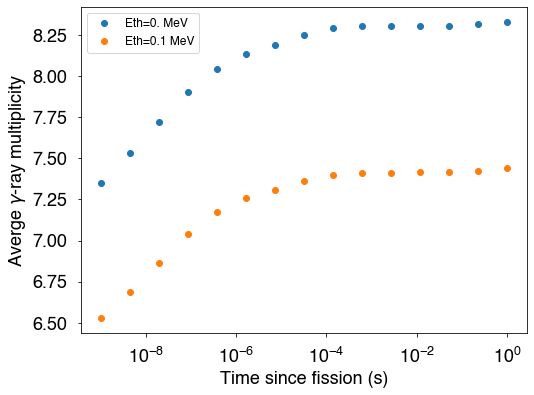

In [23]:
times,nubargTime = histTime.nubarg(timeWindow=True) # include timeWindow as a boolean or list of times (in seconds) to activate this feature
fig = plt.figure(figsize=(8,6))
plt.plot(times,nubargTime,'o',label='Eth=0. MeV')
times,nubargTime = histTime.nubarg(timeWindow=True,Eth=0.1)
plt.plot(times,nubargTime,'o',label='Eth=0.1 MeV')
plt.xlabel('Time since fission (s)')
plt.ylabel(r'Averge $\gamma$-ray multiplicity')
plt.xscale('log')
plt.legend()
plt.show()

The prompt fission gamma-ray spectrum function, pfgs(), can also be used to calculate this quantity within a certain time window since the fission event.  The time window is defined using minTime and maxTime to set the lower and upper boundaries.

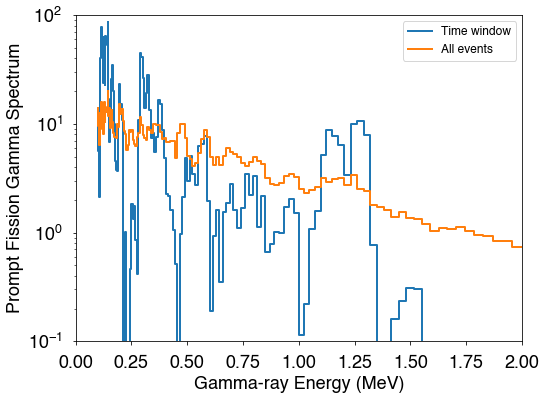

In [24]:
fig = plt.figure(figsize=(8,6))
bE,pfgsTest = histTime.pfgs(minTime=5e-8,maxTime=500e-8)
plt.step(bE,pfgsTest,label='Time window')
bE,pfgsTest = histTime.pfgs()
plt.step(bE,pfgsTest,label='All events')
plt.yscale('log')
plt.xlim(0,2)
plt.ylim(0.1,100)
plt.xlabel('Gamma-ray Energy (MeV)')
plt.ylabel('Prompt Fission Gamma Spectrum')
plt.legend()
plt.show()

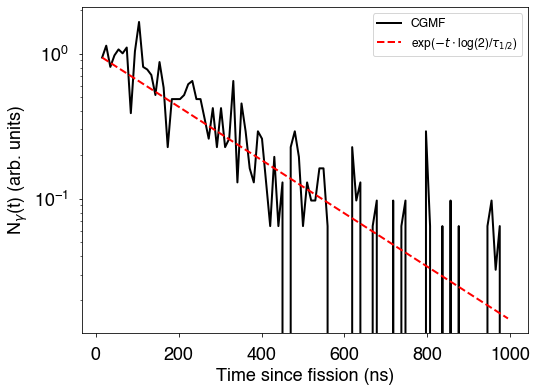

In [25]:
# calculate the gamma-ray multiplicity as a function of time since fission for a specific fission fragment
times,gMultiplicity = histTime.gammaMultiplicity(minTime=1e-8,maxTime=1e-6,Afragment=134,Zfragment=52)

# also compare to an exponential decay with the half life of the state
f = np.exp(-times*np.log(2)/1.641e-7) # the half life of 134Te is 164.1 ns
norm = gMultiplicity[0]/f[0]

fig = plt.figure(figsize=(8,6))
plt.plot(times*1e9,gMultiplicity/norm,'k-',label='CGMF')
plt.plot(times*1e9,f,'r--',label=r'exp($-t\cdot$log(2)/$\tau_{1/2}$)')
plt.legend()
plt.yscale('log')
plt.xlabel('Time since fission (ns)')
plt.ylabel(r'N$_\gamma$(t) (arb. units)')
plt.show()

In [26]:
# calculate the isomeric ratios for specific states in nuclei
# e.g. isomeric ratio for the 1/2- state in 99Nb, ground state is 9/2+, lifetime is 150 s
r = histTime.isomericRatio(thresholdTime=1,A=99,Z=41,Jm=0.5,Jgs=4.5)
print ('99Nb:',round(r,2)) 
# e.g. isomeric ratio for the 11/2- state in 133Te, ground state is 3/2+, lifetime is 917.4 s
r = histTime.isomericRatio(thresholdTime=1,A=133,Z=52,Jm=5.5,Jgs=1.5)
print ('133Te:',round(r,2))

99Nb: 0.9
133Te: 0.32


### 9. Angular Correlations
<a id='angles'></a>

For the fission fragment angular distribution with respect to the beam axis/z-axis, there is one option:  afterEmission=True/False.  afterEmission=True uses these angles after neutron emission and afterEmission=False uses these angles before neutron emission.  The default is True.

In [27]:
# calculate cos(theta) between the fragments and z-axis/beam axis
FFangles = hist.FFangles()
bins = np.linspace(-1,1,30)
h,b = np.histogram(FFangles,bins=bins,density=True)
# only light fragments
hLight,b = np.histogram(FFangles[::2],bins=bins,density=True)
# only heavy fragments
hHeavy,b = np.histogram(FFangles[1::2],bins=bins,density=True)

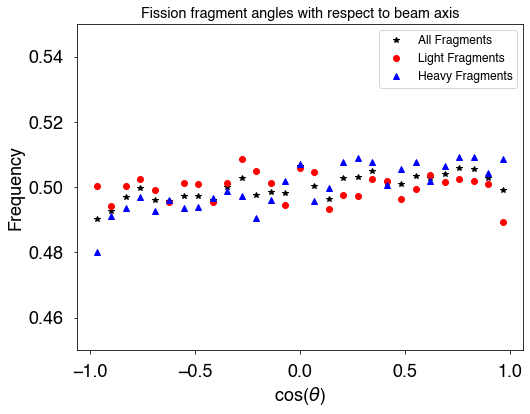

In [28]:
x = 0.5*(b[:-1]+b[1:])
fig = plt.figure(figsize=(8,6))
plt.plot(x,h,'k*',label='All Fragments')
plt.plot(x,hLight,'ro',label='Light Fragments')
plt.plot(x,hHeavy,'b^',label='Heavy Fragments')
plt.xlabel(r'cos($\theta$)')
plt.ylabel('Frequency')
plt.ylim(0.45,0.55)
plt.title('Fission fragment angles with respect to beam axis')
plt.legend()
plt.show()

There are several options when calculating the angles of the neutrons with respect to the beam axis/z-axis.  The first is including a neutron threshold energy with keyword, Eth (given in MeV).  We can also calculate these angles in the lab frame (lab=True, default) or in the center of mass frame of the compound system (lab=False).  Finally, we can include pre-fission neutrons (includePrefission=True, default) or not include them (includePreFission=False).  However, the pre-fission neutrons can only be include in the lab frame.

In [29]:
# calculate the angles between the neutrons and the z-axis/beam axis
nAllLab,nLLab,nHLab = hist.nangles(lab=True) # all neutrons, from the light fragment, from the heavy fragment
nAllCM,nLCM,nHCM = hist.nangles(lab=False) # center of mass frame of the compound

In [30]:
bins = np.linspace(-1,1,30)
hAllLab,b = np.histogram(nAllLab,bins=bins,density=True)
hLightLab,b = np.histogram(nLLab,bins=bins,density=True)
hHeavyLab,b = np.histogram(nHLab,bins=bins,density=True)
hAllcm,b = np.histogram(nAllCM,bins=bins,density=True)
hLightcm,b = np.histogram(nLCM,bins=bins,density=True)
hHeavycm,b = np.histogram(nHCM,bins=bins,density=True)

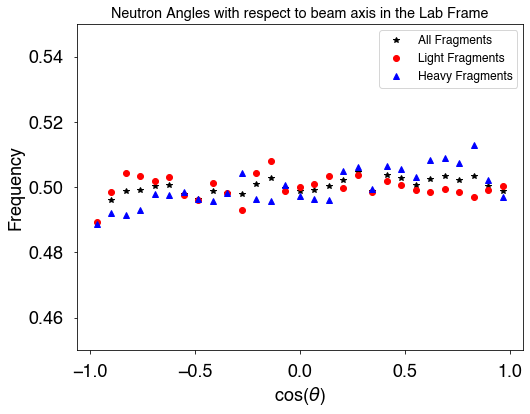

In [31]:
x = 0.5*(b[:-1]+b[1:])
fig = plt.figure(figsize=(8,6))
plt.plot(x,hAllLab,'k*',label='All Fragments')
plt.plot(x,hLightLab,'ro',label='Light Fragments')
plt.plot(x,hHeavyLab,'b^',label='Heavy Fragments')
plt.xlabel(r'cos($\theta$)')
plt.ylabel('Frequency')
plt.ylim(0.45,0.55)
plt.title('Neutron Angles with respect to beam axis in the Lab Frame')
plt.legend()
plt.show()

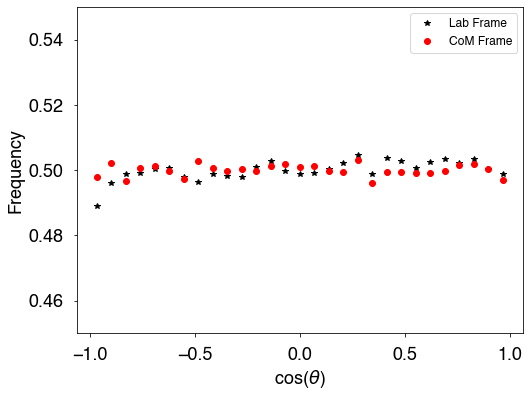

In [32]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,hAllLab,'k*',label='Lab Frame')
plt.plot(x,hAllcm,'ro',label='CoM Frame')
plt.xlabel(r'cos($\theta$)')
plt.ylabel('Frequency')
plt.ylim(0.45,0.55)
plt.legend()
plt.show()

There are again several options that we can use when calculating the angles between all pairs of neutrons (from all framgments) and the ligh fragments, all of which have been seen in the last two examples.  These include, Eth (neutron threshold energy), afterEmission (fission fragment angles are post or pre neutron emission), and includePrefission (to include or not include pre-fission neutrons).

In [33]:
# calculate the angles between the neutrons and the light fragments
nFall,nFLight,nFHeavy = hist.nFangles()
bins = np.linspace(-1,1,30)
hall,b = np.histogram(nFall,bins=bins,density=True)
hlight,b = np.histogram(nFLight,bins=bins,density=True)
hheavy,b = np.histogram(nFHeavy,bins=bins,density=True)

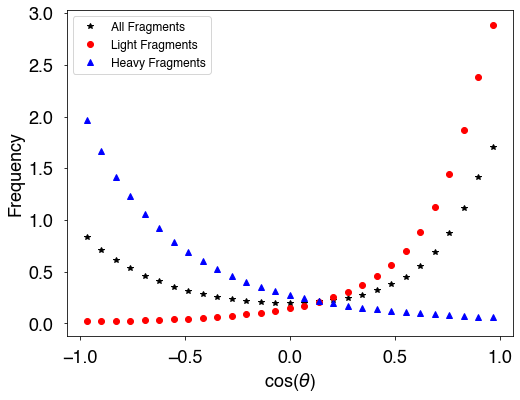

In [34]:
x = 0.5*(b[:-1]+b[1:])
fig = plt.figure(figsize=(8,6))
plt.plot(x,hall,'k*',label='All Fragments')
plt.plot(x,hlight,'ro',label='Light Fragments')
plt.plot(x,hheavy,'b^',label='Heavy Fragments')
plt.xlabel(r'cos($\theta$)')
plt.ylabel('Frequency')
plt.legend()
plt.show()